In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.spatial.distance import pdist, squareform

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
from dask.diagnostics import ProgressBar
import duckdb

sys.path.append("../scripts")
from initial_map import BarcodeMapper
from map_refiner import MapRefiner
import finder
import preprocess

import protfasta

In [2]:
cc_step1_fasta = "../data/Staller_Tl4s1_MVS_0035_I1TTGTCACCAA_CGCACGAACA_S326.fastq.gz.assembled.fastq"
cc_step1_fasta

'../data/Staller_Tl4s1_MVS_0035_I1TTGTCACCAA_CGCACGAACA_S326.fastq.gz.assembled.fastq'

# Clustering reads

In [18]:
preprocess.shorten_seq_file(cc_step1_fasta, "../data/Staller_Tl4s1_MVS_0035_I1TTGTCACCAA_CGCACGAACA_S326.txt")

In [42]:
cc_step1_reads = pd.read_csv("../data/Staller_Tl4s1_MVS_0035_I1TTGTCACCAA_CGCACGAACA_S326.txt", header = None)
cc_step1_reads

,0
0,CTACCCAGCTTAAGCCACCATGGCCCAGGACCTGGCCGCCGCCACC...
1,CTACCCAGCTTAAGCCACCATGGCCCAGGACCTGGCCGCCGCCACC...
2,ACTACCCAGCTTAAGCCACCATGACCGACTTCATCGACGAGGAGGT...
3,ACCCAGCTTAAGCCACCATGGCCCAGGACCTGGCCGCCGCCACCTT...
4,TACCCAGCTTAAGCCACCATGACCGCCTTCATCGCCGCCGCCGTGC...
...,...
77530,TACCCAGCTTAAGCCACCATGGACTCTCCCGGACCCGGCGCCACAC...
77531,ACCCAGCTTAAGCCACCATGACCTTCAGCGACCTGTGGAAGCTGCT...
77532,ACCCAGCTTAAGCCACCATGGTCCAGGACGCCGCCGCCGCCACCGC...
77533,CTACCCAGCTTAAGCCACCATGGCCCAGGACCTGGCCGCCGCCACC...


In [45]:
330 * 0.001 

0.33

In [55]:
cc_step1_reads.groupby(0).size().value_counts()

1     34633
2      5592
3      3105
4      1752
5       933
6       488
7       292
8       164
9       118
10       79
11       43
12       32
13       26
15       22
14       13
17       12
16        8
19        8
18        6
23        4
20        3
22        2
26        1
28        1
24        1
21        1
Name: count, dtype: int64

<Axes: ylabel='Count'>

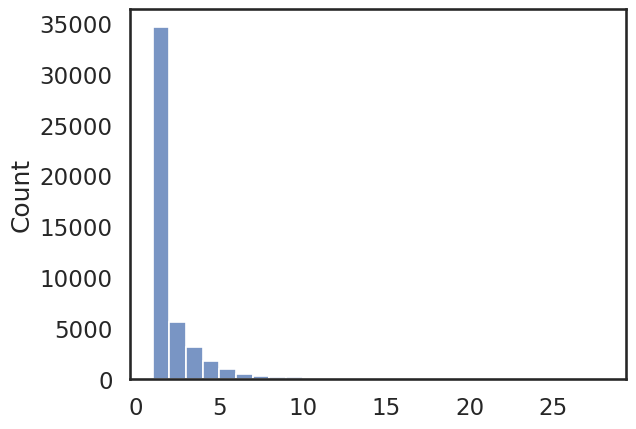

In [54]:
sns.histplot(cc_step1_reads.groupby(0).size(), binwidth = 1)

In [44]:
cc_step1_reads[0].str.len().value_counts()

0
330    16583
329    13805
331    11861
328     9802
332     7519
       ...  
237        1
359        1
390        1
345        1
274        1
Name: count, Length: 240, dtype: int64

In [59]:
read_counts = dict(cc_step1_reads[0].value_counts())
len(read_counts)

47339

In [60]:
import networkx as nx
from collections import defaultdict
import random
from joblib import Parallel, delayed
from tqdm import tqdm
import pandas as pd

def hamming_distance(s1, s2):
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

def build_graph_hash_buckets(umi_counts, threshold=1, n_jobs=-1):
    """
    Build UMI graph efficiently using hash buckets.
    Only sequences within the same bucket (masking one position) are compared.
    Supports threshold <= 1.
    """
    umis = list(umi_counts.keys())
    L = len(umis[0])
    G = nx.Graph()
    for u in umis:
        G.add_node(u, count=umi_counts[u])

    # Create buckets by masking one position at a time
    buckets = defaultdict(list)
    for umi in umis:
        for i in range(L):
            key = umi[:i] + "_" + umi[i+1:]  # mask position i
            buckets[key].append(umi)

    # Function to compute edges within a bucket
    def process_bucket(bucket):
        edges = []
        for i, u1 in enumerate(bucket):
            for u2 in bucket[i+1:]:
                if hamming_distance(u1, u2) <= threshold:
                    edges.append((u1, u2))
        return edges

    all_buckets = list(buckets.values())
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_bucket)(b) for b in tqdm(all_buckets, desc="Processing buckets")
    )

    # Flatten and add edges
    for edges in results:
        G.add_edges_from(edges)

    return G

def directional_adjacency_clustering_df_scaled(umi_counts, threshold=1, seed=None, n_jobs=-1, ratio=0.01, seq_type='umi'):
    """
    Directional adjacency clustering using the hash-bucket graph.
    Only clusters a node into a higher-count node if its count < ratio * neighbor count.
    """
    if seed is not None:
        random.seed(seed)

    G = build_graph_hash_buckets(umi_counts, threshold=threshold, n_jobs=n_jobs)
    cluster_records = []

    for component in nx.connected_components(G):
        subgraph = G.subgraph(component).copy()
        visited = set()
        selected = []

        while len(visited) < len(subgraph):
            candidates = [n for n in subgraph.nodes if n not in visited]
            if not candidates:
                break
            max_count = max(subgraph.nodes[n]["count"] for n in candidates)
            top_nodes = [n for n in candidates if subgraph.nodes[n]["count"] == max_count]
            rep = random.choice(top_nodes)
            selected.append(rep)
            visited |= {rep} | set(subgraph.neighbors(rep))

        # Assign each node to its representative
        for node in component:
            if node in selected:
                rep = node
            else:
                neighbors = set(G.neighbors(node)) & set(selected)
                eligible_reps = [n for n in neighbors if umi_counts[node] < ratio * umi_counts[n]]
                if eligible_reps:
                    rep = max(eligible_reps, key=lambda x: umi_counts[x])
                else:
                    rep = node

            cluster_records.append({
                seq_type: node,
                "count": umi_counts[node],
                "rep_" + seq_type: rep
            })

    df = pd.DataFrame(cluster_records)
    return df


In [87]:
reads_clustered = directional_adjacency_clustering_df_scaled(read_counts, threshold=1, seed=42, n_jobs=-1, ratio=0.12, seq_type = 'read')
reads_clustered


Processing buckets: 100%|██████████| 7051258/7051258 [00:29<00:00, 242810.98it/s]


,read,count,rep_read
0,ACCCAGCTTAAGCCACCATGGCCCAGGCTGCTCGAGATAACTTCGT...,28,ACCCAGCTTAAGCCACCATGGCCCAGGCTGCTCGAGATAACTTCGT...
1,ACCCAGCTTAAGCCACCATGGCCCAGGCTGCTCGAGATAACTTCGT...,26,ACCCAGCTTAAGCCACCATGGCCCAGGCTGCTCGAGATAACTTCGT...
2,ACCCAGCTTAATCCACCATGGCCCAGGCTGCTCGAGATAACTTCGT...,1,ACCCAGCTTAATCCACCATGGCCCAGGCTGCTCGAGATAACTTCGT...
3,ACCCAGCTTAAGCCACCATGGCCCAGGCTGCTCGAGATAACTTCGT...,1,ACCCAGCTTAAGCCACCATGGCCCAGGCTGCTCGAGATAACTTCGT...
4,ACTACCCAGCTTAAGCCACCATGGCCCAGGCTGCTCGTGATAACTT...,1,ACTACCCAGCTTAAGCCACCATGGCCCAGGCTGCTCGAGATAACTT...
...,...,...,...
47334,ACTACCCAGCTTAAGCCACCATGGCCCAGGACCTGGCCGCCGCCAC...,1,ACTACCCAGCTTAAGCCACCATGGCCCAGGACCTGGCCGCCGCCAC...
47335,ACCCAGCTTAAGCCACCATGGCCCAGGACCTGGCCGCCGCACCTTC...,1,ACCCAGCTTAAGCCACCATGGCCCAGGACCTGGCCGCCGCACCTTC...
47336,CTACCCAGCTTAAGCCACCATGGACTCTCCCGGACCCGGCTTCACA...,1,CTACCCAGCTTAAGCCACCATGGACTCTCCCGGACCCGGCTTCACA...
47337,CTACCCAGCTTAAGCCACCATGGCCCAGGACCTGGCCGCCGCCACC...,1,CTACCCAGCTTAAGCCACCATGGCCCAGGACCTGGCCGCCGCCACC...


In [88]:
reads_clustered_counts = pd.DataFrame(reads_clustered["rep_read"].value_counts()).reset_index()
reads_clustered_counts

,rep_read,count
0,ACTACCCAGCTTAAGCCACCATGGCCCAGGCTGCTCGAGATAACTT...,6
1,TACCCAGCTTAAGCCACCATGGACTCTCCCGGACCCGGCTTCACAC...,4
2,CTACCCAGCTTAAGCCACCATGGCCCAGGACCCAGTGGACCTGGGG...,4
3,ACCCAGCTTAAGCCACCATGGACTCTCCCGGACCCGGCTTCACACC...,4
4,ACCCAGCTTAAGCCACCATGGCCCGCTAGCACCGGATGTCTCGAGA...,4
...,...,...
47170,TACCCAGCTTAAGCCACCATGGCCCAGGACCTGAGCCTGAGCACCT...,1
47171,TACCCAGCTTCAGCCACCATGGCCCAGGACCTGGACGACGACACCT...,1
47172,TACCCAGCTTAAGCCACCATGGCCCAGGACCTGGCCGCCGCCACCT...,1
47173,CTACCCAGCTTAAGCCACCATGGCCAGCGACCTGGCCGCCGCCACC...,1


In [94]:
len(cc_step1_reads[0].value_counts())

47339

In [104]:
percent_merged = (1 - len(reads_clustered_counts) / len(cc_step1_reads[0].value_counts())) * 100
print(f"{np.round(percent_merged, 2)}% of unique reads should be merged")

0.35% of unique reads should be merged


In [113]:
cc_step1_reads

,0
0,CTACCCAGCTTAAGCCACCATGGCCCAGGACCTGGCCGCCGCCACC...
1,CTACCCAGCTTAAGCCACCATGGCCCAGGACCTGGCCGCCGCCACC...
2,ACTACCCAGCTTAAGCCACCATGACCGACTTCATCGACGAGGAGGT...
3,ACCCAGCTTAAGCCACCATGGCCCAGGACCTGGCCGCCGCCACCTT...
4,TACCCAGCTTAAGCCACCATGACCGCCTTCATCGCCGCCGCCGTGC...
...,...
77530,TACCCAGCTTAAGCCACCATGGACTCTCCCGGACCCGGCGCCACAC...
77531,ACCCAGCTTAAGCCACCATGACCTTCAGCGACCTGTGGAAGCTGCT...
77532,ACCCAGCTTAAGCCACCATGGTCCAGGACGCCGCCGCCGCCACCGC...
77533,CTACCCAGCTTAAGCCACCATGGCCCAGGACCTGGCCGCCGCCACC...


In [114]:
rep_read_dict = dict(zip(reads_clustered["read"], reads_clustered["rep_read"]))
rep_read_dict

{'ACCCAGCTTAAGCCACCATGGCCCAGGCTGCTCGAGATAACTTCGTATAATGTATGCTATTGTGTAGGCCGGCCATAGGGCCCCGCTATTGACGAGACAAGCGGTCCACTCTATAACGCACTCGAGCCTGCAGGTCTAGTTGGTGTGAT': 'ACCCAGCTTAAGCCACCATGGCCCAGGCTGCTCGAGATAACTTCGTATAATGTATGCTATTGTGTAGGCCGGCCATAGGGCCCCGCTATTGACGAGACAAGCGGTCCACTCTATAACGCACTCGAGCCTGCAGGTCTAGTTGGTGTGAT',
 'ACCCAGCTTAAGCCACCATGGCCCAGGCTGCTCGAGATAACTTCGTATAATGTATGCTATTGTGTAGGCCGGCCATAGGGCCCCGCTATTGACGAGACAAGCGGTCCACTCTATAACGCACTCGAGCCTGCAGGTCTAGTTGGTGTGA': 'ACCCAGCTTAAGCCACCATGGCCCAGGCTGCTCGAGATAACTTCGTATAATGTATGCTATTGTGTAGGCCGGCCATAGGGCCCCGCTATTGACGAGACAAGCGGTCCACTCTATAACGCACTCGAGCCTGCAGGTCTAGTTGGTGTGA',
 'ACCCAGCTTAATCCACCATGGCCCAGGCTGCTCGAGATAACTTCGTATAATGTATGCTATTGTGTAGGCCGGCCATAGGGCCCCGCTATTGACGAGACAAGCGGTCCACTCTATAACGCACTCGAGCCTGCAGGTCTAGTTGGTGTGA': 'ACCCAGCTTAATCCACCATGGCCCAGGCTGCTCGAGATAACTTCGTATAATGTATGCTATTGTGTAGGCCGGCCATAGGGCCCCGCTATTGACGAGACAAGCGGTCCACTCTATAACGCACTCGAGCCTGCAGGTCTAGTTGGTGTGA',
 'ACCCAGCTTAAGCCACCATGGCCCAGGCTGCTCGAGATAACTTCGTATAATGTATGCTATTGTGTAGGCCGGCCATAGGGC

In [116]:
cc_step1_reads["mapped_read"] = cc_step1_reads[0].map(rep_read_dict)
cc_step1_reads

,0,mapped_read
0,CTACCCAGCTTAAGCCACCATGGCCCAGGACCTGGCCGCCGCCACC...,CTACCCAGCTTAAGCCACCATGGCCCAGGACCTGGCCGCCGCCACC...
1,CTACCCAGCTTAAGCCACCATGGCCCAGGACCTGGCCGCCGCCACC...,CTACCCAGCTTAAGCCACCATGGCCCAGGACCTGGCCGCCGCCACC...
2,ACTACCCAGCTTAAGCCACCATGACCGACTTCATCGACGAGGAGGT...,ACTACCCAGCTTAAGCCACCATGACCGACTTCATCGACGAGGAGGT...
3,ACCCAGCTTAAGCCACCATGGCCCAGGACCTGGCCGCCGCCACCTT...,ACCCAGCTTAAGCCACCATGGCCCAGGACCTGGCCGCCGCCACCTT...
4,TACCCAGCTTAAGCCACCATGACCGCCTTCATCGCCGCCGCCGTGC...,TACCCAGCTTAAGCCACCATGACCGCCTTCATCGCCGCCGCCGTGC...
...,...,...
77530,TACCCAGCTTAAGCCACCATGGACTCTCCCGGACCCGGCGCCACAC...,TACCCAGCTTAAGCCACCATGGACTCTCCCGGACCCGGCGCCACAC...
77531,ACCCAGCTTAAGCCACCATGACCTTCAGCGACCTGTGGAAGCTGCT...,ACCCAGCTTAAGCCACCATGACCTTCAGCGACCTGTGGAAGCTGCT...
77532,ACCCAGCTTAAGCCACCATGGTCCAGGACGCCGCCGCCGCCACCGC...,ACCCAGCTTAAGCCACCATGGTCCAGGACGCCGCCGCCGCCACCGC...
77533,CTACCCAGCTTAAGCCACCATGGCCCAGGACCTGGCCGCCGCCACC...,CTACCCAGCTTAAGCCACCATGGCCCAGGACCTGGCCGCCGCCACC...


In [118]:
cc_step1_reads[["mapped_read"]].to_csv("../data/Staller_Tl4s1_MVS_0035_I1TTGTCACCAA_CGCACGAACA_S326_mapped.txt", header = None, index = None)

# Map from clustered reads vs unclustered

In [3]:
mapper = BarcodeMapper(seq_file = ['../data/Staller_Tl4s1_MVS_0035_I1TTGTCACCAA_CGCACGAACA_S326_mapped.txt'],
                        bc_names = ["ADBC2", "HawkBCs", "RTBC", "AD"],
                        preceders = ["CTCGAGATAACTTCGTATAATGTATGCTAT", "GAGCTCGCTAGC", "GGCCGGCCATAGGGCCCC", "CACCATG"],
                        posts = ["GGCCGGCCATAGGGCCCC", "CTCGAGATAA", "GCGGTCCA", "GGATCCG"],
                        lengths = [6, 9, 16, 162],
                      reverse_complement=False)
mapped_df = mapper.create_map()
mapped_df.head()

('../data/Staller_Tl4s1_MVS_0035_I1TTGTCACCAA_CGCACGAACA_S326_mapped.txt',)


,ADBC2,ADBC2_qual,HawkBCs,HawkBCs_qual,RTBC,RTBC_qual,AD,AD_qual,Designed
0,<NA>,True,<NA>,True,<NA>,True,<NA>,True,1
1,<NA>,True,ACCAAGATC,True,<NA>,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1
2,<NA>,True,<NA>,True,<NA>,True,<NA>,True,1
3,<NA>,True,<NA>,True,<NA>,True,<NA>,True,1
4,<NA>,True,<NA>,True,<NA>,True,<NA>,True,1


In [4]:
preprocess.save_parquet(mapped_df, '../output/CC_nkx2_2_clustered.parquet')

[########################################] | 100% Completed | 1.27 ss


In [99]:
refiner_clustered = MapRefiner(db_path = "../duckdb/CC_nkx2_2_clustered",
                      cols = ["ADBC2", "HawkBCs", "RTBC", "AD"],
                     reads_threshold = 5,
                     column_pairs = [("AD", ("ADBC2", "HawkBCs")), (("ADBC2", "HawkBCs"), "RTBC")])

In [100]:
refiner_clustered.refine_map_from_parquet('../output/CC_nkx2_2_clustered.parquet/*')

Refining maps: 100%|██████████| 5/5 [00:00<00:00,  9.22step/s]


In [101]:
initial_clustered = refiner_clustered.get_map_df('map1_initial')
initial_clustered

,ADBC2,ADBC2_qual,HawkBCs,HawkBCs_qual,RTBC,RTBC_qual,AD,AD_qual,Designed
0,None,True,None,True,None,True,None,True,1
1,None,True,ACCAAGATC,True,None,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1
2,None,True,None,True,None,True,None,True,1
3,None,True,None,True,None,True,None,True,1
4,None,True,None,True,None,True,None,True,1
...,...,...,...,...,...,...,...,...,...
77530,GGGCGA,True,CCATCGACA,True,TAGCTAGAGTAAATTT,True,GACTCTCCCGGACCCGGCGCCACACCTCACGACAGCGCTCCCTACG...,True,1
77531,TGATCC,True,CCGTGTTGT,True,TGGTACGTAAATCTAC,True,ACCTTCAGCGACCTGTGGAAGCTGCTGCCCGAGAACAACGTGCTGT...,True,1
77532,TATATC,True,ATAGCACAC,True,ATCTGACTACGCGGTA,True,GTCCAGGACGCCGCCGCCGCCACCGCCCAGGCCGGCATTCCCGCCA...,True,1
77533,TGAACC,True,ATCAGGACC,True,ACATATAAAAAGATAT,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...,True,1


In [102]:
refiner_clustered.save_loss_table()

,map,description,num_rows,% of previous step,% of total reads
0,map1_initial,Initial combinations,77535,100.00,100.00
1,map2_quality_designed,After removing low quality and undesigned,77535,100.00,100.00
2,map3_grouped,Grouped counts,19812,25.55,25.55
3,map4_thresholded,Filtered by reads_threshold > 5,1999,10.09,2.58
4,map5_unique_target,Filtered for unique targets,1590,79.54,2.05


In [103]:
map5_unique_target_clustered = refiner_clustered.get_map_df('map5_unique_target')
map5_unique_target_clustered

,ADBC2,HawkBCs,RTBC,AD,count
0,CCATAA,CACCGATTG,CAGCGTTTAACAAGCG,GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...,304
1,ACCCCC,ATCCGCTGT,TGAAACGTTTAAGGGA,GCCCAGGACCCAGTGGACCTGG,229
2,ACAAGA,AGATCGAAG,GCAAATTAATGATGTC,GCCCAGGAGCAGTGGACCTGG,224
3,GTCAGC,CCATTAACG,TGTAAAATGGGGCTGG,GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCTACG...,211
4,AAAGCT,ACAAGAAGC,GGCGGCACCCCATTAC,CCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGTATCCCA...,173
...,...,...,...,...,...
1585,TGTGCC,AACCTACGC,GGCTAAAGACTATATA,GCCCAGGACCTGAGCAGCCTGACCTTCAGGCCGGCATTCCCTTCAG...,6
1586,ATTTTC,AAGAGGTGC,GGAATAGAGTGAGAGA,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,6
1587,TTAGTA,ACACTCTAG,CCAAAACTTTATCCGA,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,6
1588,GTTCTC,AAGGTACGT,AAAAAAAGAGAAGCAA,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,6


In [104]:
map5_unique_target_clustered_refined = map5_unique_target_clustered.dropna()
map5_unique_target_clustered_refined = map5_unique_target_clustered_refined[map5_unique_target_clustered_refined["ADBC2"].str.len() == 6]
map5_unique_target_clustered_refined = map5_unique_target_clustered_refined[map5_unique_target_clustered_refined["HawkBCs"].str.len() == 9]
map5_unique_target_clustered_refined = map5_unique_target_clustered_refined[map5_unique_target_clustered_refined["RTBC"].str.len() == 16]
map5_unique_target_clustered_refined = map5_unique_target_clustered_refined[map5_unique_target_clustered_refined["AD"].str.len() == 162]
#map5_unique_target_clustered_refined = map5_unique_target_clustered_refined[map5_unique_target_clustered_refined["count"] > 5]
map5_unique_target_clustered_refined

,ADBC2,HawkBCs,RTBC,AD,count
0,CCATAA,CACCGATTG,CAGCGTTTAACAAGCG,GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...,304
3,GTCAGC,CCATTAACG,TGTAAAATGGGGCTGG,GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCTACG...,211
5,GTACAA,CCATCGGTT,TTGCAGAATAGCTGCA,GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCGCCG...,170
7,AGTAAA,CCGCAGTTA,ACATATTCTTGAAGGA,ACCGACTTCATCGACGAGGAGGTGATCATGAGCATCGTGATCGAGA...,162
9,ATTATT,CCGGAGAAT,CCGTTTCCATAAGTTT,ACCGACTTCATCGACGAGGAGGTGGCCATGAGCGCCGTGATCGAGA...,148
...,...,...,...,...,...
1584,GTGTAC,CCATATTCG,AACAAATTAAAAAAGG,GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCTACG...,6
1586,ATTTTC,AAGAGGTGC,GGAATAGAGTGAGAGA,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,6
1587,TTAGTA,ACACTCTAG,CCAAAACTTTATCCGA,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,6
1588,GTTCTC,AAGGTACGT,AAAAAAAGAGAAGCAA,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,6


In [83]:
map5_unique_target_clustered_refined["concat_ADBC"] = map5_unique_target_clustered_refined["ADBC2"] + map5_unique_target_clustered_refined["HawkBCs"]
map5_unique_target_clustered_refined

,ADBC2,HawkBCs,RTBC,AD,count,concat_ADBC
3,ATTATT,CCGGAGAAT,CCGTTTCCATAAGTTT,ACCGACTTCATCGACGAGGAGGTGGCCATGAGCGCCGTGATCGAGA...,148,ATTATTCCGGAGAAT
6,TGGGAC,ACCGGATGT,CACAAAACGTGGCGCC,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,134,TGGGACACCGGATGT
7,CCCGAT,CCATTCTGC,CACTACGAAAGTCATA,CCTCCCACCGACGTGAGCCTGGGCGACGAGCTGCACCTGGACGGCG...,130,CCCGATCCATTCTGC
9,ATGGCA,CCACAGAAC,ATATACAGTGAGCTTT,AGACTGCTGGGCCAGAGCATGGACGAGAGCGGCCTGCCTCAGCTGA...,123,ATGGCACCACAGAAC
11,TGTTTA,CATTCGTAC,GGGCATAGGCTTGACA,ACCGACTTCATCGACGAGGAGGTGTTCATGAGCTTCGTGATCGAGA...,116,TGTTTACATTCGTAC
...,...,...,...,...,...,...
1553,ACAACA,AACGTCACT,ATAAATGACAGGTTTC,TTCGCCGACGCCACCCAGGCCGCCCTGCAGGCCGGCATTCCCTTCA...,2,ACAACAAACGTCACT
1554,GCCTGG,ACAATACGG,GAAAAGAGTAAGAGCT,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,2,GCCTGGACAATACGG
1555,GTTATA,CAACTACAG,ATCTAATTGTTGCGGG,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,2,GTTATACAACTACAG
1556,GAACAT,ACTTCAGCC,GGTAAACGTAATGCCA,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,2,GAACATACTTCAGCC


Text(0.5, 0.98, 'BCs per AD')

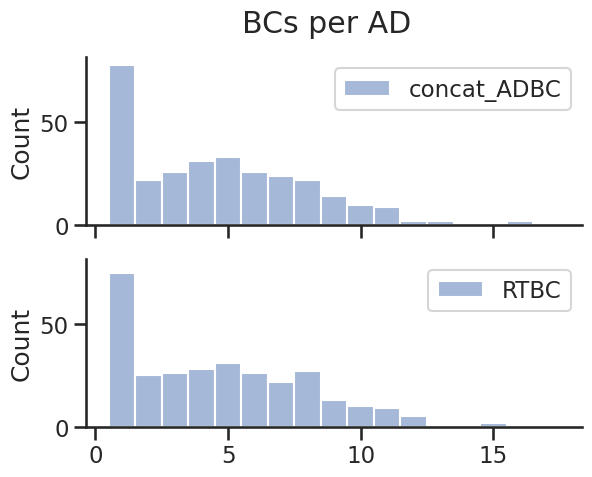

In [98]:
import matplotlib.pyplot as plt
sns.set_style("ticks")
fig, axs = plt.subplots(2,1, sharex=True, sharey = True)
sns.histplot(map5_unique_target_clustered_refined[["AD", "concat_ADBC"]].drop_duplicates().groupby("AD").count(), binwidth = 1, ax = axs[0], discrete=True)
sns.histplot(map5_unique_target_clustered_refined[["AD", "RTBC"]].drop_duplicates().groupby("AD").count(), binwidth = 1, ax = axs[1], discrete=True)
sns.despine()
fig.suptitle("BCs per AD")

In [78]:
map5_unique_target_clustered_refined["count"].value_counts()

count
2      87
9      56
6      51
4      50
11     47
       ..
85      1
83      1
77      1
76      1
148     1
Name: count, Length: 90, dtype: int64

In [71]:
len(map5_unique_target_clustered["AD"].value_counts())

356

In [24]:
refiner_unclustered = MapRefiner(db_path = "../duckdb/CC_nkx2_2_unclustered",
                      cols = ["ADBC2", "HawkBCs", "RTBC", "AD"],
                     reads_threshold = 5,
                     column_pairs = [("AD", ("ADBC2", "HawkBCs")), (("ADBC2", "HawkBCs"), "RTBC")])

In [19]:
refiner_unclustered.refine_map_from_parquet('../output/CC_nkx2_2.parquet/*')

Refining maps: 100%|██████████| 5/5 [00:00<00:00, 13.50step/s]


In [20]:
refiner_unclustered.save_loss_table()

,map,description,num_rows,% of previous step,% of total reads
0,map1_initial,Initial combinations,77535,100.00,100.00
1,map2_quality_designed,After removing low quality and undesigned,51229,66.07,66.07
2,map3_grouped,Grouped counts,7757,15.14,10.00
3,map4_thresholded,Filtered by reads_threshold > 5,1578,20.34,2.04
4,map5_unique_target,Filtered for unique targets,1436,91.00,1.85


In [16]:
initial_unlustered = refiner_unclustered.get_map_df('map1_initial')
initial_unlustered

,ADBC2,ADBC2_qual,HawkBCs,HawkBCs_qual,RTBC,RTBC_qual,AD,AD_qual,Designed
0,None,False,None,False,None,False,None,False,0
1,None,False,ACCAAGATC,True,None,False,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,0
2,None,False,None,False,None,False,None,False,0
3,None,False,None,False,None,False,None,False,0
4,None,False,None,False,None,False,None,False,0
...,...,...,...,...,...,...,...,...,...
77530,GGGCGA,True,CCATCGACA,True,TAGCTAGAGTAAATTT,True,GACTCTCCCGGACCCGGCGCCACACCTCACGACAGCGCTCCCTACG...,True,1
77531,TGATCC,True,CCGTGTTGT,True,TGGTACGTAAATCTAC,True,ACCTTCAGCGACCTGTGGAAGCTGCTGCCCGAGAACAACGTGCTGT...,True,1
77532,TATATC,True,ATAGCACAC,True,ATCTGACTACGCGGTA,True,GTCCAGGACGCCGCCGCCGCCACCGCCCAGGCCGGCATTCCCGCCA...,True,0
77533,TGAACC,True,ATCAGGACC,True,ACATATAAAAAGATAT,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...,True,1


In [141]:
initial_unlustered[initial_unlustered["Designed"] == 1]

,ADBC2,ADBC2_qual,HawkBCs,HawkBCs_qual,RTBC,RTBC_qual,AD,AD_qual,Designed
8,None,False,CAGTTACAC,True,None,False,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1
9,CGATCC,True,CCACATCAT,True,GTAAAGTAGTAAATAC,True,AGCATGGACGAGAGCGGCCTGCCTCAGCTGACCAGCTACGACTGCG...,True,1
10,ACAGAC,True,ACAAGCGTT,True,CGATAATTTAGAATGT,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1
11,GAATTG,True,AACCTACGC,True,TAGCGTATTGAGCGAA,True,GCCCAGGACCTGAGCAGCCTGACCTTCCAGGCCGGCATTCCCTTCA...,True,1
12,ACCAGA,True,ACATTGCCG,True,AGAATTTGTTCGTCTG,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGAGCAGCGGCGCCTACT...,True,1
...,...,...,...,...,...,...,...,...,...
77529,CAATCA,True,CCAGAAGAT,True,ATGAACAAGCTCGGCA,True,GAGGAGCCTCAGAGCGATCCCAGCGTGGAGCCTCCTCTGAGCCAGG...,True,1
77530,GGGCGA,True,CCATCGACA,True,TAGCTAGAGTAAATTT,True,GACTCTCCCGGACCCGGCGCCACACCTCACGACAGCGCTCCCTACG...,True,1
77531,TGATCC,True,CCGTGTTGT,True,TGGTACGTAAATCTAC,True,ACCTTCAGCGACCTGTGGAAGCTGCTGCCCGAGAACAACGTGCTGT...,True,1
77533,TGAACC,True,ATCAGGACC,True,ACATATAAAAAGATAT,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...,True,1
